### Linear Dynamical System


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
d=100
r = 5
Q = np.random.randn(d,r)
Q, _ = np.linalg.qr(Q)
D = 1 - np.random.rand(r)
D = np.diag(D)# /D.max())
M = Q@D@Q.T

def linear_map(x, sigma =0.1):
    return M @ x + sigma*np.random.randn(*x.shape)

def lds(x0,n, sigma = 0.1):
    x = np.empty((n,d),dtype=np.float64)
    x[0] = x0
    for t in range(1,n):
        x[t] = linear_map(x[t-1], sigma = sigma)


In [5]:
#kernel = Matern(nu=0.5, length_scale=0.5)
kernel = Linear(coef0=0.)
rank = 5
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 500
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 100
test_X = np.random.randn(test_size,d, test_repetitions)
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,:,i] = linear_map(test_X[:,:,i].T).T

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        X = np.random.randn(train_size,d)
        Y = linear_map(X.T).T
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,:,k], test_Y[:,:,k])

KernelRidgeRegression: 100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


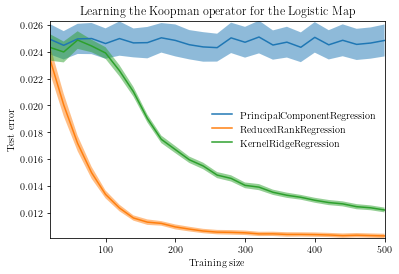

In [6]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for the Logistic Map")
plt.savefig("figs/logistic_map_error.pdf")

In [ ]:
#kernel = Matern(nu=0.5, length_scale=0.5)
kernel = Linear(coef0=0.)
rank = 5
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 500
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 100
test_data = lds(np.random.randn(d, test_repetitions), test_size +1)
test_X = test_data[:,:,:-1]
test_Y = test_data[:,:,1:]

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        data = lds(np.random.randn(d), test_size +1)
        X = test_data[:-1]
        Y = test_data[1:]
        X = np.random.randn(train_size,d)
        Y = linear_map(X.T).T
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,:,k], test_Y[:,:,k])

In [ ]:
#kernel = Matern(nu=0.5, length_scale=0.5)
kernel = Linear(coef0=0.)
rank = 5
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 500
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 100
test_X = np.random.randn(test_size,d, test_repetitions)
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,:,i] = linear_map(test_X[:,:,i].T).T

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        X = np.random.randn(train_size,d)
        Y = linear_map(X.T).T
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
            #e = estimator(kernel, rank)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,:,k], test_Y[:,:,k])